Hi


In [12]:
#########################
# read all files from get_familiar
# save them in a dictionary of datasets

import pandas as pd
import os

data_dir = '../d1_get_familiar/data/get_familiar'
datasets = {}
for file in os.listdir(data_dir):
    if file.endswith('.feather'):
        dataset_name = file[:file.index('_person')]
        datasets[dataset_name] = pd.read_feather(os.path.join(data_dir, file))

In [13]:
# the names of the datasets
print(datasets.keys(), '\n')
# check the sizes of datasets
total_size = 0
for name, df in datasets.items():
    size = df.memory_usage(deep=True).sum()
    total_size += size
    print(f"Dataset '{name}' size: {size / (1024 ** 2):.2f} MB")
print(f"\nTotal size of all datasets: {total_size / (1024 ** 2):.2f} MB")

dict_keys(['breathing', 'ecg', 'insulin', 'glucose', 'summary', 'accel']) 

Dataset 'breathing' size: 9.91 MB
Dataset 'ecg' size: 99.12 MB
Dataset 'insulin' size: 0.00 MB
Dataset 'glucose' size: 0.09 MB
Dataset 'summary' size: 6.94 MB
Dataset 'accel' size: 79.30 MB

Total size of all datasets: 195.36 MB


In [15]:
print(datasets['glucose'].info())
datasets['insulin']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1438 entries, 2014-10-01 19:14:00 to 2014-10-06 16:54:02
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   glucose  1438 non-null   float64
 1   type     1438 non-null   object 
dtypes: float64(1), object(1)
memory usage: 33.7+ KB
None


,fast_insulin,slow_insulin
datetime,,
2014-10-01 10:06:00,7,NaN
2014-10-01 16:50:00,4,NaN
2014-10-01 19:28:00,6,NaN
2014-10-01 22:27:00,8,NaN
2014-10-01 23:48:00,0,31.0
2014-10-02 00:45:00,2,NaN
2014-10-02 10:10:00,3,NaN
2014-10-02 12:34:00,12,NaN
2014-10-02 21:24:00,5,NaN


# Data loading from Sasha's preprocessing

In [1]:
# Convert Google Drive link to direct download format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_id = '1URua1BRmcTgkwU1nGPWRkrxhabWVotxH'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
df_tochunk = pd.read_feather(url)

In [2]:
file_id = '1qGfSIb9EEJ4ZxlWnBcsILgh9LbHAiMld'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
gl_d1 = pd.read_feather(url)

Residual Network ResNet are a improvement on CNN, they adress the vanishing gradient issue so they outperform CNNs in complex task (e.g. classification) especially for deep networks
(https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/)

The goal is at first to use a basic CNN 1D with functionnal API to allow more flexibility when complexifing the model. C1D is good for our purpose because it is good at recognozing pattern in a short period interval -> What we want here to predict a dip in glucose level based on our ECG (c.f. Sasha's article on link between ECG and Glucose level)


Do the same with an LSTM which is more suitable for long term recognision

# Chunks and Data

In [44]:
import hypopredict.train_test_split as tts

CHUNK_SIZE = 1*10*250 # 1 hour of samples of 4 miliseocnds
STEP_SIZE = 1*250 # x minute steps

chunks = tts.chunkify(df_tochunk, chunk_size=CHUNK_SIZE, step_size=STEP_SIZE)

In [45]:
chunks[0]

,EcgWaveform
datetime,
2014-10-04 06:34:57.423,297
2014-10-04 06:34:57.427,297
2014-10-04 06:34:57.431,297
2014-10-04 06:34:57.435,297
2014-10-04 06:34:57.439,297
...,...
2014-10-04 06:35:07.403,3798
2014-10-04 06:35:07.407,3798
2014-10-04 06:35:07.411,3798


In [106]:
onset_times = tts.get_HG_onset_times(gl_d1.loc['2014-10-04'], threshold=3.9)
onset_times

[Timestamp('2014-10-04 09:15:00'), Timestamp('2014-10-04 11:14:01')]

In [47]:
FORECAST_WINDOW = pd.Timedelta(minutes=30)

target_labels = tts.generate_target_labels(chunks,
                                        onset_times=onset_times,
                                        forecast_window=FORECAST_WINDOW)

np.float64(0.13854679802955666)

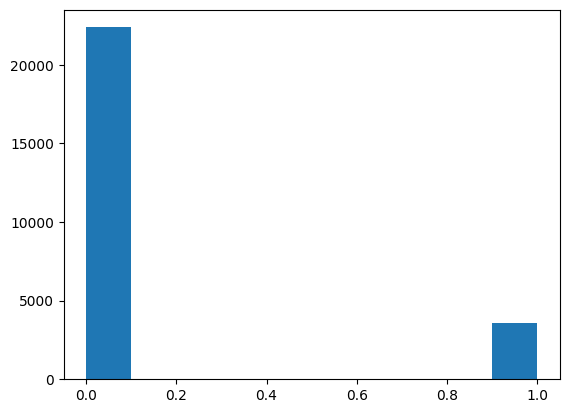

In [49]:
import matplotlib.pyplot as plt

plt.hist(target_labels);
np.mean(target_labels)

In [50]:
SAMPLING_RATE = 250  # Hz
TEST_SIZE = 0.2  # 20% for testing

X_train_chunks, X_test_chunks, y_train_chunks, y_test_chunks = tts.train_test_split_chunks(
    chunks,
    chunk_size=CHUNK_SIZE,
    step_size=STEP_SIZE,
    target_labels=target_labels,
    forecast_window=FORECAST_WINDOW,
    sampling_rate=SAMPLING_RATE,
    test_size=TEST_SIZE,
)

In [55]:
print("Train chunk lengths:",
      {c.shape[0] for c in X_train_chunks})
print("Test chunk lengths:",
      {c.shape[0] for c in X_test_chunks})
print(len(X_train_chunks), "train chunks")

print("Train chunk columns:",
      X_train_chunks[0].columns)
print("Test  chunk columns:",
      X_test_chunks[0].columns)

Train chunk lengths: {2500}
Test chunk lengths: {1250, 2500, 1000, 2250, 750, 2000, 500, 1750, 250, 1500}
18976 train chunks
Train chunk columns: Index(['EcgWaveform'], dtype='object')
Test  chunk columns: Index(['EcgWaveform'], dtype='object')


In [ ]:
from tensorflow.keras.utils import pad_sequences

X_test_chunks_pad = pad_sequences(X_test_chunks, maxlen=X_train_chunks[0].shape[0], dtype='float32', padding='post', value=-1)

#Transform my X_test_chunk_pad into a Dataframe
X_test_chunks_pad = [pd.DataFrame(c, columns=X_test_chunks[0].columns) for c in X_test_chunks_pad]


(array([   0.,    0.,    0.,    0.,    0., 5197.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

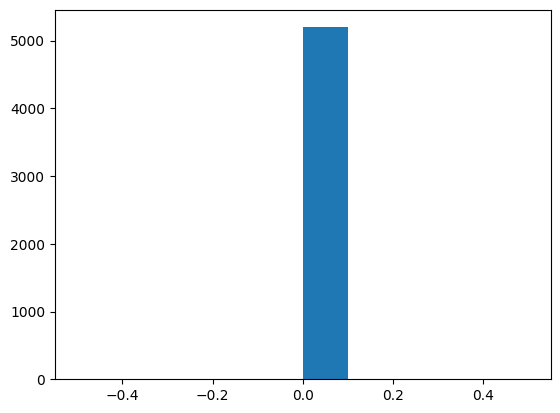

In [114]:
plt.hist(y_test)

In [ ]:
print("Test chunk lengths:",
      {c.shape[0] for c in X_test_chunks_pad})
#give me the index of the first chunk that is shorter than the maxlen
for i, c in enumerate(X_test_chunks):
    if c.shape[0] < X_train_chunks[0].shape[0]:
        print("First shorter chunk index:", i)
        break
display(X_test_chunks[5188], X_test_chunks_pad[5188].shape)

Test chunk lengths: {2500}
First shorter chunk index: 5188


,EcgWaveform
datetime,
2014-10-04 13:47:52.423,1942
2014-10-04 13:47:52.427,1942
2014-10-04 13:47:52.431,1942
2014-10-04 13:47:52.435,1941
2014-10-04 13:47:52.439,1940
...,...
2014-10-04 13:48:01.403,1956
2014-10-04 13:48:01.407,1956
2014-10-04 13:48:01.411,1957


(2500, 1)

# C1D Architecture

The idea is to create a basic architecture for a CNN where we would have access to the output of each layer to be able to combine with another model (LSTM)  

<Axes: xlabel='datetime'>

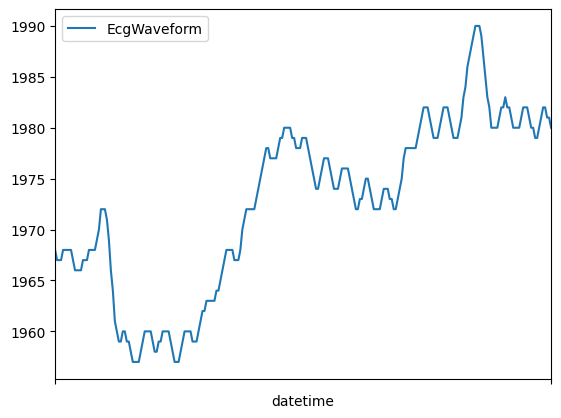

In [ ]:
# subset the data df_tochunk in order to only have the 2014-04-10 dataframe
df_tochunk_1stday = df_tochunk.loc["2014-04-10 12:45":"2014-04-10 12:45:00"]
df_tochunk_1stday.plot()


In [87]:
import numpy as np

def chunks_to_array(chunks: list[pd.DataFrame], feature_cols: list[str]):
    return np.stack([chunk[feature_cols].values for chunk in chunks], axis=0)

feature_cols = ["EcgWaveform"]

X_train = chunks_to_array(X_train_chunks, feature_cols)  # (N_train, chunk_size, n_features)
X_test  = chunks_to_array(X_test_chunks_pad, feature_cols)   # (N_test, chunk_size, n_features)

y_train = np.array(y_train_chunks)  # (N_train,)
y_test  = np.array(y_test_chunks)   # (N_test,)

In [ ]:
# Create a very simple CNN model for testing using functional API
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#My input shape must be my X_train shape
input_shape = (X_train.shape[1], X_train.shape[2])
print("Input shape:", input_shape)

inputs = keras.Input(shape=input_shape)
x = layers.Masking(mask_value=-1)(inputs)
x = layers.Conv1D(32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","AUC","Precision","Recall",tfa.metrics.AUC(curve='PR', name='avg_precision'), tf.keras.metrics.AUC(curve='PR', name='pr_auc')])

Input shape: (2500, 1)


/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_3 (Masking)             │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2498, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1249, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1247, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 623, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 39872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,551,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,558,273 (9.76 MB)

 Trainable params: 2,558,273 (9.76 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 0.4989 - Precision: 0.1812 - Recall: 0.0889 - accuracy: 0.7509 - loss: 24.6939
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 0.5194 - Precision: 0.1463 - Recall: 0.0017 - accuracy: 0.8088 - loss: 0.4980
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 0.5561 - Precision: 0.5161 - Recall: 0.0044 - accuracy: 0.8103 - loss: 0.5390
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 0.5731 - Precision: 0.7632 - Recall: 0.0161 - accuracy: 0.8124 - loss: 0.4674
Epoch 5/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 0.5781 - Precision: 0.7877 - Recall: 0.0319 - accuracy: 0.8147 - loss: 0.4640


In [95]:
y_test_pred_proba = model.predict(X_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


(array([2.040e+02, 3.800e+01, 4.700e+01, 4.813e+03, 4.500e+01, 2.500e+01,
        1.000e+01, 7.000e+00, 3.000e+00, 5.000e+00]),
 array([0.        , 0.0607316 , 0.1214632 , 0.1821948 , 0.2429264 ,
        0.30365801, 0.3643896 , 0.42512122, 0.48585281, 0.54658443,
        0.60731602]),
 <BarContainer object of 10 artists>)

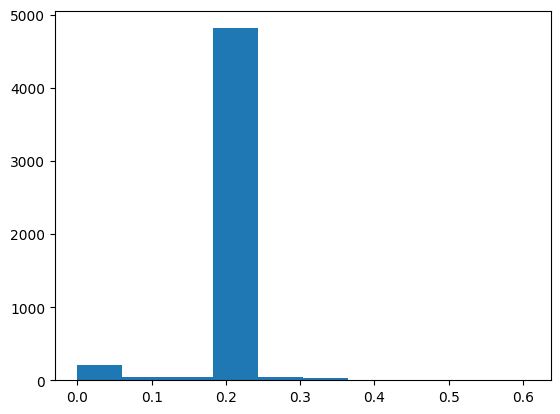

In [97]:
plt.hist(y_test_pred_proba)

In [109]:
#import classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_proba > 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5197
           1       0.00      0.00      0.00         0

    accuracy                           1.00      5197
   macro avg       0.50      0.50      0.50      5197
weighted avg       1.00      1.00      1.00      5197



/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beha

PR-AUC: 0.5000


/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


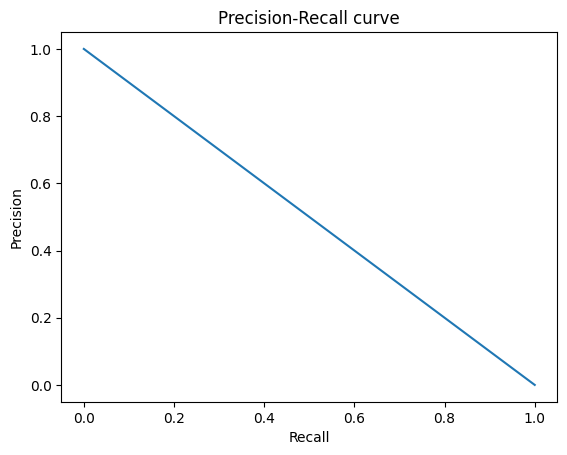

In [ ]:
# I want the PR-AUC curves for my predictions
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# plot it
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [ ]:
# save model architetcture in .keras and weights in .pickel to models/Dan
model.save('../models/Dan/hypopredict_cnn_model.keras')


In [ ]:
# load my model and weight from models/Dan
from tensorflow import keras

model2 = keras.models.load_model('../models/Dan/hypopredict_cnn_model.keras')


/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [118]:
model2.summary()
model2.predict(X_test)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_3 (Masking)             │ (None, 2500, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2498, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1249, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1247, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 623, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 39872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,551,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,674,821 (29.28 MB)

 Trainable params: 2,558,273 (9.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,116,548 (19.52 MB)

 27/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/home/danielfarkas/.pyenv/versions/3.12.9/envs/hypopredict/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[1.4565831e-01],
       [1.8561307e-01],
       [1.1430566e-01],
       ...,
       [0.0000000e+00],
       [2.3810779e-16],
       [0.0000000e+00]], shape=(5197, 1), dtype=float32)

# LSTM Architecture

Same idea as above

In [8]:
#Create a very simple LSTM model for testing using functional API
def create_simple_lstm(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.LSTM(50, return_sequences=True)(inputs)
    x = layers.LSTM(50)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs, outputs)
    return model


In [3]:
from hypopredict.train_test_split import hello

message = hello()
message

Hello from hypopredict.train_test_split module!!
